In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import glob

import cv2
import time
import shutil

In [3]:
ROOT_DIR = "/content/drive/My Drive/Colab_Notebooks/Zalo2022_LivenessDetection"
GROUP_DIR = f"{ROOT_DIR}/data/Zalo22/LivenessDetection"

TRAIN_DATA_PATH = f"{ROOT_DIR}/data/train/videos"
TEST_DATA_PATH = f"{ROOT_DIR}/data/public/videos"

os.chdir(ROOT_DIR)

# Visualization

In [49]:
import time

fname = os.listdir(TRAIN_DATA_PATH)[1]
cap = cv2.VideoCapture(f"{TRAIN_DATA_PATH}/{fname}")

total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
num_frames = 20
step = int(np.floor(total_frames / num_frames))

begin = time.time()

count = 0
i = 0
imgs = []
while True:
    success,image = cap.read()
    if success:
        if count % step == 0:
            imgs.append(image)
            i += 1
            if i == num_frames:
                break
        count += 1
    else:
        break 

print(time.time() - begin)

0.6805083751678467


In [50]:
import time

fname = os.listdir(TRAIN_DATA_PATH)[1]
cap = cv2.VideoCapture(f"{TRAIN_DATA_PATH}/{fname}")

total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
num_frames = 20
step = int(np.floor(total_frames / num_frames))
frames = [i*step for i in range(num_frames)]
begin = time.time()

count = 0
i = 0
imgs = []

for frame in frames:
    cap.set(1,frame) # 0 is the frame you want
    ret, img = cap.read()
    if ret:
        imgs.append(img)

print(time.time() - begin)

5.535654544830322


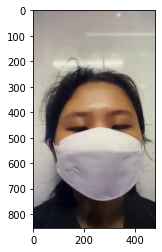

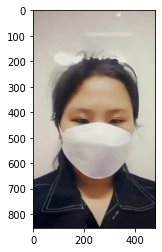

In [ ]:
cap.set(1,0)
ret, img = cap.read(0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

cap.set(1,100)
ret, img = cap.read(0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)



# Read video & extract information

In [ ]:
print("Number of videos in training set", len(os.listdir(f"{TRAIN_DATA_PATH}")))
print("Number of videos in test set", len(os.listdir(f"{TEST_DATA_PATH}")))

Number of videos in training set 1168
Number of videos in test set 350


In [ ]:
vid_name = []
vid_height = []
vid_width = []
vid_duration = []
vid_frame_count = []
vid_fps = []

corrupted_name = []


for fname in tqdm(sorted(os.listdir(TRAIN_DATA_PATH), key=lambda x: int(x.split('.', 1)[0]))):
    fpath = os.path.join(TRAIN_DATA_PATH, fname)
    
    vid = cv2.VideoCapture(fpath)
    height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
    if height < 1:
        corrupted_name.append(fname)
    else:
        frame_count = vid.get(cv2.CAP_PROP_FRAME_COUNT)
        fps = vid.get(cv2.CAP_PROP_FPS)
        duration = round(frame_count/fps, 2)

        vid_name.append(fname)
        vid_height.append(height)
        vid_width.append(width)
        vid_duration.append(duration)
        vid_frame_count.append(frame_count)
        vid_fps.append(fps)

100%|██████████| 1168/1168 [00:59<00:00, 19.50it/s]


In [ ]:
train_metadata = pd.DataFrame({'img_name':vid_name, 
                                'width':vid_width, 
                                'height':vid_height, 
                                'duration': vid_duration, 
                                'frame_count': vid_frame_count, 
                                'FPS': vid_fps})

train_metadata

,img_name,width,height,duration,frame_count,FPS
0,1.mp4,480.0,852.0,5.06,126.0,24.92
1,2.mp4,1080.0,1920.0,5.04,121.0,24.00
2,3.mp4,2160.0,3840.0,5.06,162.0,32.00
3,5.mp4,1080.0,1920.0,5.00,160.0,32.00
4,7.mp4,720.0,1280.0,5.00,145.0,29.00
...,...,...,...,...,...,...
1162,1880.mp4,480.0,852.0,5.07,152.0,30.00
1163,1881.mp4,1080.0,1920.0,5.00,160.0,32.00
1164,1882.mp4,480.0,852.0,5.00,150.0,30.00
1165,1884.mp4,720.0,1280.0,5.00,150.0,30.00


In [ ]:
train_metadata.to_csv(f"{ROOT_PATH}/data/train_metadata.csv")

# Frame video

In [ ]:
def extract_frame(in_path, out_path):
    print("Number of video:", len(os.listdir(in_path)))
    if os.path.exists(out_path):
        if len(os.listdir(in_path)) == len(os.listdir(out_path)): 
            print("Output folder is existed!")
            return
        else:
            shutil.rmtree(out_path)
    os.mkdir(out_path)
    
    for fname in tqdm(os.listdir(in_path)):
        out_fname_path = f"{out_path}/{fname.split('.')[0]}"
        os.mkdir(out_fname_path)
        fpath = os.path.join(in_path, fname)
        vidcap = cv2.VideoCapture(fpath)

        success,image = vidcap.read()
        count = 0
        while success:
            cv2.imwrite(f"{out_fname_path}/{count}.jpg", image)     # save frame as JPEG file      
            success,image = vidcap.read()
            #print('Read a new frame: ', success)
            count += 1

extract_frame(TRAIN_DATA_PATH, f"{ROOT_PATH}/data/train_frames")

Number of video: 1168


 12%|█▎        | 146/1168 [15:24<2:15:26,  7.95s/it]

In [ ]:
import cv2
import subprocess

def read_frames(folder, fname):
  if not fname.endswith('mp4'):
    if not os.path.exists(folder + 'videos/' + fname):
      return
    assert subprocess.call(f"rm -r {folder + 'videos/' + fname}", shell = True) == 0, {folder + 'videos/' + fname}
    print(f"Deleted {folder + 'videos/' + fname}")
    return
  assert os.path.exists(folder + 'videos/' + fname)

  vidcap = cv2.VideoCapture(folder + 'videos/' + fname)
  fname = fname.split('.')[0]
  if os.path.exists(folder + 'extracted_frames/' + fname ):
    if len(os.listdir(folder + 'extracted_frames/' + fname )) > 50:
      return
    else:
      assert subprocess.call(f"rm -r {folder + 'extracted_frames/' + fname}", shell = True) == 0
  else:
    os.mkdir(folder + 'extracted_frames/' + fname)
    
  success,image = vidcap.read()
  
  count = 0
  cv2.imwrite(folder + 'extracted_frames/' + f"{fname}/%d.jpg" % count, image) 
  while True:
    count += 1
    success,image = vidcap.read()
    if not success:
      break
    
    cv2.imwrite(folder + 'extracted_frames/' + f"{fname}/%d.jpg" % count, image) 
  
  print(f'Extracted {count + 1} framse from {fname}')